In [1]:
%cd ..

import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
import seaborn as sns
pd.set_option('display.max_columns', None)


/run/media/nazif/2F946E411BA61D49/thesis


In [2]:
class DropRowsCache:
    total_dropped = 0
    
    @classmethod
    def drop_rows_and_report(cls, df, condition):
        filtered_df = df.loc[condition]
        num_dropped = filtered_df.shape[0]
        cls.total_dropped += num_dropped
        df_dropped = df.drop(filtered_df.index)
        
        print(f"Number of dropped rows: {num_dropped}")
        print(f"Total number of dropped rows: {cls.total_dropped}")
        
        return df_dropped

In [3]:
df = pd.read_csv("results/1_generate_data.csv")

df.head()

,mrna_start,mrna_end,pred_energy,mirna_start,mirna_end,mirna_dot_bracket_5to3,id,mirna_sequence,mirna_accession,enst,extended_mrna_sequence,extended_mrna_start,extended_mrna_end,clash_mrna_sequence,clash_mrna_start,clash_mrna_end,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,alignment_string,pred_num_basepairs,pred_seed_basepairs,bp_difference,seed_bp_difference,mirna_length,mre_start,mre_end,mre_region
0,22,45,-27.7,0,20,)))))))))))))))))))).,0727A-1038930_1,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000340828,TTTAATATTTTTTTCTAGAAAACAGGTGACATTTGTATCTACGATA...,1760,1920,ATTTGTATCTACGATAAAAATTTTTATACAGAACCTACTGCCTCAA...,1790,1890,noncanonical_seed,20,6,-25.1,1111111111111111111100,20,6,0,0,22,22,44,TTTATACAGAACCTACTGCCTC
1,11,30,-26.2,0,18,))))))))).)))))))).,L1HS-1112536_1,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000343455,TGCCAAGGAAATCAGCTAAATTACTACAAGCAGGAAATACCCGTGC...,3826,3958,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,3856,3928,9-mer,17,6,-24.4,1111111110111111110000,17,6,0,0,22,11,33,CGTGCAACCAACTACCTCATAT
2,3,24,-23.6,0,21,.)))))).))))))))))))).,L2HS-818542_2,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000436639,GCAGAACTCCTTTATGCTCTGAGAGCCATTACCCGCTATATGACCT...,2354,2464,ACCCGCTATATGACCTGATGCCTTTCCTTCATTAAAGATGATTCTG...,2384,2434,noncanonical_seed,19,6,-22.2,0111111011111111111110,19,6,0,0,22,3,25,CGCTATATGACCTGATGCCTTT
3,3,24,-23.8,0,21,)))))))...)))))))))))),L2HS-1161339_2,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000282516,AAATAAGACCCCAGCTCATGGTTAAACATGCAATGACTATGCAACC...,6539,6653,CAATGACTATGCAACCATACCTTACCACTAAATGTAGTACGCAAAA...,6569,6623,noncanonical_seed,18,6,-22.1,1111111000111111111111,19,6,1,0,22,3,25,TGACTATGCAACCATACCTTAC
4,2,24,-24.0,0,21,))))))))))))))...)))).,L2-407944_2,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000340139,ACAGCAAAATTGAGTTCAACAACACAAAACAATACTGGGAAACCTG...,1133,1238,AATACTGGGAAACCTGCTACTTCGTCAGCTAACCAGAAACCTGTG,1163,1208,noncanonical_seed,18,6,-21.9,1111111111111100011110,18,6,0,0,22,2,24,TACTGGGAAACCTGCTACTTCG


In [4]:
# initiating drop rows method with cache
cache = DropRowsCache()

# dropping rows with low structural stability (energy close to 0)
cond_energy = df['true_energy'] > -5
df = cache.drop_rows_and_report(df, cond_energy)

# dropping rows where true seed base pairs doesn't match true seed type
cond_6mer = (df["true_seed_basepairs"] <= 4) & (df["true_seed_type"] == "6-mer")
cond_7mer = (df["true_seed_basepairs"] <= 4) & (df["true_seed_type"] == "7-mer")
cond_8mer = (df["true_seed_basepairs"] <= 4) & (df["true_seed_type"] == "8-mer")

df = cache.drop_rows_and_report(df, cond_6mer)
df = cache.drop_rows_and_report(df, cond_7mer)
df = cache.drop_rows_and_report(df, cond_8mer)

# dropping rows where true number of bp is lower than 5
cond_true_numbp = df['true_num_basepairs'] < 5
df = cache.drop_rows_and_report(df, cond_true_numbp)

# dropping rows where predicted number of bp is lower than 5
cond_pred_numbp = df['pred_num_basepairs'] < 5
df = cache.drop_rows_and_report(df, cond_pred_numbp)

Number of dropped rows: 87
Total number of dropped rows: 87
Number of dropped rows: 119
Total number of dropped rows: 206
Number of dropped rows: 86
Total number of dropped rows: 292
Number of dropped rows: 33
Total number of dropped rows: 325
Number of dropped rows: 16
Total number of dropped rows: 341
Number of dropped rows: 6
Total number of dropped rows: 347


# dropping rows where CLASH sequence not matching ENSEMBL 60

In [5]:
# these indices are generated in preprocess_clash file
rows_to_drop = [4508, 6518, 8028, 10039, 15835, 17039]
df.drop(index=rows_to_drop, inplace=True)

# visualizing the df

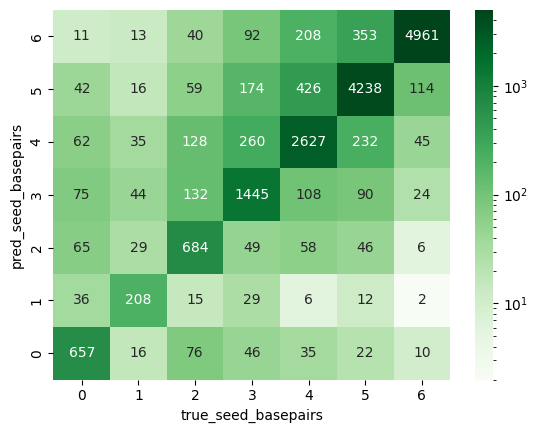

In [6]:
asd = df[["pred_seed_basepairs", "true_seed_basepairs"]]

pivot_table = asd.pivot_table(index='pred_seed_basepairs', columns='true_seed_basepairs', aggfunc=len, fill_value=0)
pivot_table = pivot_table[::-1]

# Create a logarithmic color scaling norm
norm = mcolors.LogNorm(vmin=pivot_table.values.min(), vmax=pivot_table.values.max())

sns.heatmap(pivot_table, annot=True, fmt='d', cmap='Greens', norm=norm)
plt.show()

In [7]:
df.head()

,mrna_start,mrna_end,pred_energy,mirna_start,mirna_end,mirna_dot_bracket_5to3,id,mirna_sequence,mirna_accession,enst,extended_mrna_sequence,extended_mrna_start,extended_mrna_end,clash_mrna_sequence,clash_mrna_start,clash_mrna_end,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,alignment_string,pred_num_basepairs,pred_seed_basepairs,bp_difference,seed_bp_difference,mirna_length,mre_start,mre_end,mre_region
0,22,45,-27.7,0,20,)))))))))))))))))))).,0727A-1038930_1,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000340828,TTTAATATTTTTTTCTAGAAAACAGGTGACATTTGTATCTACGATA...,1760,1920,ATTTGTATCTACGATAAAAATTTTTATACAGAACCTACTGCCTCAA...,1790,1890,noncanonical_seed,20,6,-25.1,1111111111111111111100,20,6,0,0,22,22,44,TTTATACAGAACCTACTGCCTC
1,11,30,-26.2,0,18,))))))))).)))))))).,L1HS-1112536_1,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000343455,TGCCAAGGAAATCAGCTAAATTACTACAAGCAGGAAATACCCGTGC...,3826,3958,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,3856,3928,9-mer,17,6,-24.4,1111111110111111110000,17,6,0,0,22,11,33,CGTGCAACCAACTACCTCATAT
2,3,24,-23.6,0,21,.)))))).))))))))))))).,L2HS-818542_2,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000436639,GCAGAACTCCTTTATGCTCTGAGAGCCATTACCCGCTATATGACCT...,2354,2464,ACCCGCTATATGACCTGATGCCTTTCCTTCATTAAAGATGATTCTG...,2384,2434,noncanonical_seed,19,6,-22.2,0111111011111111111110,19,6,0,0,22,3,25,CGCTATATGACCTGATGCCTTT
3,3,24,-23.8,0,21,)))))))...)))))))))))),L2HS-1161339_2,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000282516,AAATAAGACCCCAGCTCATGGTTAAACATGCAATGACTATGCAACC...,6539,6653,CAATGACTATGCAACCATACCTTACCACTAAATGTAGTACGCAAAA...,6569,6623,noncanonical_seed,18,6,-22.1,1111111000111111111111,19,6,1,0,22,3,25,TGACTATGCAACCATACCTTAC
4,2,24,-24.0,0,21,))))))))))))))...)))).,L2-407944_2,TGAGGTAGTAGGTTGTATAGTT,MIMAT0000062,ENST00000340139,ACAGCAAAATTGAGTTCAACAACACAAAACAATACTGGGAAACCTG...,1133,1238,AATACTGGGAAACCTGCTACTTCGTCAGCTAACCAGAAACCTGTG,1163,1208,noncanonical_seed,18,6,-21.9,1111111111111100011110,18,6,0,0,22,2,24,TACTGGGAAACCTGCTACTTCG


In [8]:
# export to csv
cols_to_keep = ["id", 'mrna_start', 'mrna_end', 'pred_energy', 'mirna_start', 'mirna_end',
                'mirna_dot_bracket_5to3', 'mirna_sequence', "mirna_accession", "mre_region", "enst",
                "extended_mrna_start", "extended_mrna_end", "extended_mrna_sequence", "clash_mrna_start", "clash_mrna_end", "mre_start", "mre_end"]

positive_df_results = df[cols_to_keep]
positive_df_results.to_csv("results/2_positive_data.csv", index=False)